In [1]:
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

from sklearn.metrics import confusion_matrix
import itertools

In [28]:
#path = "/Users/tarekulislam/Desktop/seniorprojecteeg/Tarekul_Workspace/capstone2/20140306_1133-epo.fif"
path2 = '/Volumes/flash64/OneDrive_1_11-28-2018/20140205_1114_epo.fif'
epoch = mne.read_epochs(path2,preload=True)

Reading /Volumes/flash64/OneDrive_1_11-28-2018/20140205_1114_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1908 matching events found
Applying baseline correction (mode: mean)
1908 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [29]:
epoch.drop_channels(ch_names=[ 'LL4', 'L12'])

<EpochsFIF  |   1908 events (all good), 0 - 0.5 sec, baseline [0, 0], ~475.4 MB, data loaded,
 'b-f1-pic': 60
 'b-f1-snd': 60
 'b-f1-spk': 100
 'b-f1-wrd': 79
 'b-f2-pic': 60
 'b-f2-snd': 60
 'b-f2-spk': 100
 'b-f2-wrd': 79
 'b-tg-pic': 60
 'b-tg-snd': 80
 'b-tg-spk': 79
 'b-tg-wrd': 80
 'f-f1-pic': 100
 'f-f1-snd': 59
 'f-f1-spk': 99
 'f-f1-wrd': 79
 'f-f2-pic': 100
 'f-f2-snd': 59
 'f-f2-spk': 99
 'f-f2-wrd': 79
 'f-tg-pic': 99
 'f-tg-snd': 99
 'f-tg-spk': 79
 'f-tg-wrd': 60>

In [30]:
epoch.drop_channels(ch_names=[ 'Nasium', 'VEOG'])

<EpochsFIF  |   1908 events (all good), 0 - 0.5 sec, baseline [0, 0], ~467.9 MB, data loaded,
 'b-f1-pic': 60
 'b-f1-snd': 60
 'b-f1-spk': 100
 'b-f1-wrd': 79
 'b-f2-pic': 60
 'b-f2-snd': 60
 'b-f2-spk': 100
 'b-f2-wrd': 79
 'b-tg-pic': 60
 'b-tg-snd': 80
 'b-tg-spk': 79
 'b-tg-wrd': 80
 'f-f1-pic': 100
 'f-f1-snd': 59
 'f-f1-spk': 99
 'f-f1-wrd': 79
 'f-f2-pic': 100
 'f-f2-snd': 59
 'f-f2-spk': 99
 'f-f2-wrd': 79
 'f-tg-pic': 99
 'f-tg-snd': 99
 'f-tg-spk': 79
 'f-tg-wrd': 60>

In [31]:
epoch.get_data().shape

(1908, 125, 257)

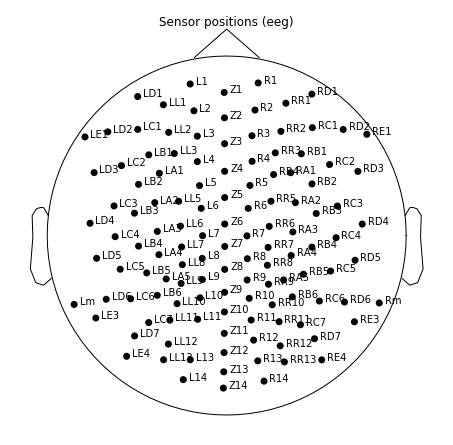

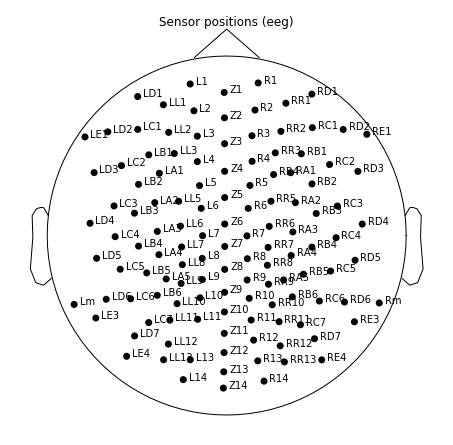

In [7]:
"""
Plot sensors
"""

montage = mne.channels.read_montage('ANT_DukeWaveGuard_128_electrode_montages_updated_V4') 
epoch.set_montage(montage)  
epoch.plot_sensors(show_names=True)

    using multitaper spectrum estimation with 7 DPSS windows


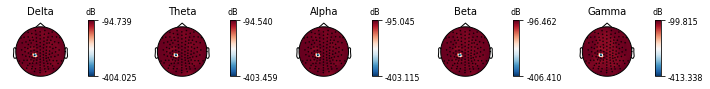

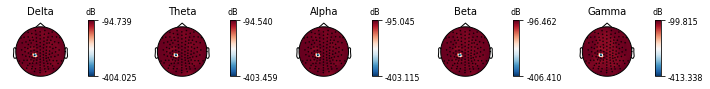

In [8]:
"""
Plot Band topomaps
"""
bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
(12, 30, 'Beta'), (30, 200, 'Gamma')]
epoch.plot_psd_topomap(bands = bands,low_bias=True)

In [35]:
"""
Filter Epoch data for visual language vs visual non-language
Visual Language stim code : VVLL
Visual non-language stim code: VVNN
"""

languageStimCodes = ["VVLL"]
nonLanguageStimCodes = ["VVNN"]

stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
}

def find_stim_combo(epochObj,stimCombos1,stimCombos2):
    events = epochObj.events
    numOfEvents = epoch.events.shape[0]
    events_new = []
    combo = []
    
    for i in range(0,numOfEvents,3):
        temp = []
        #print('three')
        for h in range(i,i+3):
            #print(events[h][-1])
            combo.append(events[h])
            
        combo_tuple = (combo[0][-1],combo[1][-1],combo[2][-1])   
        #print(combo_tuple)
        for k in stimCombos1:
            if k == stim_combinations[combo_tuple]:
                #print("found visual")
                combo[0][-1] = 100
                combo[1][-1] = 100
                combo[2][-1] = 100
                temp.append(combo[0])
                temp.append(combo[1])
                temp.append(combo[2])
        
        for j in stimCombos2:
            if j == stim_combinations[combo_tuple]:
                #print("found audio")
                combo[0][-1] = 200
                combo[1][-1] = 200
                combo[2][-1] = 200
                temp.append(combo[0])
                temp.append(combo[1])
                temp.append(combo[2])        
        
        for p in temp:
            events_new.append(p)
        combo = []
    return events_new




In [33]:
epoch_copy = epoch.copy()

In [34]:
find_stim_combo(epoch_copy,languageStimCodes,nonLanguageStimCodes)

(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(14, 21, 13)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(20, 15, 19)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(5, 12, 4)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(17, 24, 16)
(5, 12, 4)
(5, 12, 4)
(5, 

[array([327160,      0,    200]),
 array([327436,      0,    200]),
 array([327703,      0,    200]),
 array([328357,      0,    200]),
 array([328616,      0,    200]),
 array([328900,      0,    200]),
 array([329486,      0,    200]),
 array([329727,      0,    200]),
 array([329994,      0,    200]),
 array([330545,      0,    200]),
 array([330795,      0,    200]),
 array([331036,      0,    200]),
 array([331596,      0,    200]),
 array([331863,      0,    200]),
 array([332113,      0,    200]),
 array([332672,      0,    200]),
 array([332922,      0,    200]),
 array([333181,      0,    200]),
 array([333740,      0,    200]),
 array([333990,      0,    200]),
 array([334249,      0,    200]),
 array([334800,      0,    200]),
 array([335050,      0,    200]),
 array([335282,      0,    200]),
 array([335842,      0,    200]),
 array([336118,      0,    200]),
 array([336359,      0,    200]),
 array([336919,      0,    200]),
 array([337194,      0,    200]),
 array([337444

In [36]:
binary_epoch = epoch_copy[(epoch_copy.events[:,-1]==100) | (epoch_copy.events[:,-1]==200)].copy()

In [37]:
binary_epoch.get_data().shape

(300, 125, 257)

In [38]:
binary_epoch.events

array([[327160,      0,    200],
       [327436,      0,    200],
       [327703,      0,    200],
       [328357,      0,    200],
       [328616,      0,    200],
       [328900,      0,    200],
       [329486,      0,    200],
       [329727,      0,    200],
       [329994,      0,    200],
       [330545,      0,    200],
       [330795,      0,    200],
       [331036,      0,    200],
       [331596,      0,    200],
       [331863,      0,    200],
       [332113,      0,    200],
       [332672,      0,    200],
       [332922,      0,    200],
       [333181,      0,    200],
       [333740,      0,    200],
       [333990,      0,    200],
       [334249,      0,    200],
       [334800,      0,    200],
       [335050,      0,    200],
       [335282,      0,    200],
       [335842,      0,    200],
       [336118,      0,    200],
       [336359,      0,    200],
       [336919,      0,    200],
       [337194,      0,    200],
       [337444,      0,    200],
       [33

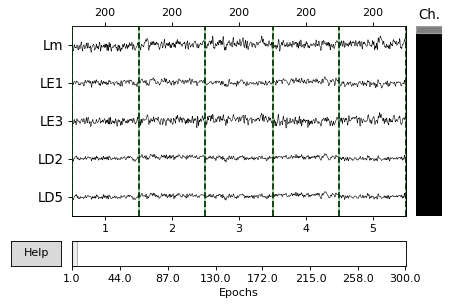

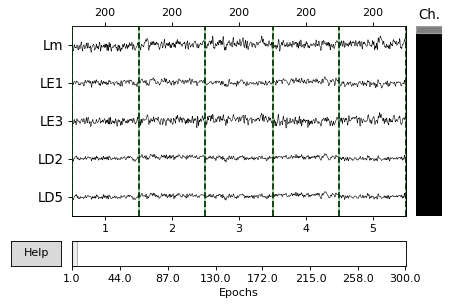

In [39]:
binary_epoch.plot(n_channels=5,n_epochs=5)

In [108]:
"""
Classify filtered data and check results
"""
features = binary_epoch.get_data()
target = binary_epoch.events[:,-1]

#print("shape of data",features.shape)
#print("shape of target array",target.shape)
#print(target.ravel().shape)

#clf = make_pipeline(Vectorizer(),StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=2,max_features='sqrt'))

def classifier(features,target):
    clf = RandomForestClassifier(n_estimators=100,random_state=0)
    #clf = LogisticRegression()
    cv = StratifiedKFold(n_splits=5,shuffle=True)
    scores = []
    
    for train,test in cv.split(features,target):
        preds = []
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

    

        twoD_X_train = Vectorizer().fit_transform(X_train)
        print('original shape of training set',(X_train.shape))
        print('Vectorized shape of training set',(twoD_X_train.shape))
        clf.fit(twoD_X_train,y_train)

        #print(clf.feature_importances_.shape)
        twoD_X_test = Vectorizer().fit_transform(X_test)
        print('original shape of test set',(X_test.shape))
        print('Vectorized shape of test set',(twoD_X_test.shape))
        
        preds.append(clf.predict(twoD_X_test))
        print('shape of y_test is: ',np.array(y_test).shape)
        #print(np.array(preds).shape)
        d = np.transpose(preds).ravel()
        print('shape of pred is: ',d.shape)
        
        print('Accuracy on training set {:.3f}'.format(clf.score(twoD_X_train,y_train)))
        print('Accuracy on test set {:.3f}'.format(clf.score(twoD_X_test,y_test)))
        scores.append(clf.score(twoD_X_test,y_test))
        
        target_names = ['lang', 'non-lang']
        report = classification_report(y_test, d, target_names=target_names)
        print(report)
        
    
    
    return np.mean(scores)


In [109]:
print("mean classification score", classifier(features,target))

original shape of training set (240, 125, 257)
Vectorized shape of training set (240, 32125)
(32125,)
original shape of test set (60, 125, 257)
Vectorized shape of test set (60, 32125)
shape of y_test is:  (60,)
shape of pred is:  (60,)
Accuracy on training set 1.000
Accuracy on test set 0.717
             precision    recall  f1-score   support

       lang       0.71      0.50      0.59        24
   non-lang       0.72      0.86      0.78        36

avg / total       0.71      0.72      0.71        60

original shape of training set (240, 125, 257)
Vectorized shape of training set (240, 32125)
(32125,)
original shape of test set (60, 125, 257)
Vectorized shape of test set (60, 32125)
shape of y_test is:  (60,)
shape of pred is:  (60,)
Accuracy on training set 1.000
Accuracy on test set 0.700
             precision    recall  f1-score   support

       lang       0.64      0.58      0.61        24
   non-lang       0.74      0.78      0.76        36

avg / total       0.70      0.70  

In [115]:
binary_epoch.get_data().shape

(300, 125, 257)

In [124]:
"""
Reorganize features importance array by sum per three?

"""
def importantChannelFinder(features,target):
    forest = RandomForestClassifier(n_estimators=100,random_state=0)
    #clf = LogisticRegression()
    cv = StratifiedKFold(n_splits=5,shuffle=True)
    scores = []
    
    for train,test in cv.split(features,target):
        preds = []
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

    

        twoD_X_train = Vectorizer().fit_transform(X_train)
        forest.fit(twoD_X_train,y_train)

        """manipulate array to 125 features"""
        impt = []
        for e in forest.feature_importances_:
            impt.append(e)

        print("shape of important feat array: ",np.array(impt).shape)
        temp = []
        time = binary_epoch.get_data().shape[2]
        channel_time = binary_epoch.get_data().shape[1] * binary_epoch.get_data().shape[2]
        for i in range(0,channel_time,time):
            #print(i)
            hold = []
            for j in range(i,i+time):
                hold.append(impt[j])

            temp.append(np.sum(hold))    

        print("new shape of important feat array: ",np.array(temp).shape) 
        
        twoD_X_test = Vectorizer().fit_transform(X_test)
        
        
        preds.append(forest.predict(twoD_X_test))
        
        d = np.transpose(preds).ravel()
        
        scores.append(forest.score(twoD_X_test,y_test))
        
        target_names = ['lang', 'non-lang']
        report = classification_report(y_test, d, target_names=target_names)
        print(report)
        
    
    
    return np.mean(scores)

In [125]:
importantChannelFinder(features,target)

shape of important feat array:  (32125,)
new shape of important feat array:  (125,)
             precision    recall  f1-score   support

       lang       0.63      0.50      0.56        24
   non-lang       0.71      0.81      0.75        36

avg / total       0.68      0.68      0.68        60

shape of important feat array:  (32125,)
new shape of important feat array:  (125,)
             precision    recall  f1-score   support

       lang       0.75      0.75      0.75        24
   non-lang       0.83      0.83      0.83        36

avg / total       0.80      0.80      0.80        60

shape of important feat array:  (32125,)
new shape of important feat array:  (125,)
             precision    recall  f1-score   support

       lang       0.83      0.62      0.71        24
   non-lang       0.79      0.92      0.85        36

avg / total       0.80      0.80      0.79        60

shape of important feat array:  (32125,)
new shape of important feat array:  (125,)
             precis

0.7533333333333333

In [186]:
"""
pipeling for converting data from 3D to 2D using vectorizer and
RandomForest for classification 
"""


#clf = make_pipeline(Vectorizer(),StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=2,max_features='sqrt'))

def classifier(features,target):
    clf = RandomForestClassifier(n_estimators=100,random_state=0)
    cv = StratifiedKFold(n_splits=5,shuffle=True)
    scores = []
    preds = []
    for train,test in cv.split(features,target):
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

    

        aa = Vectorizer().fit_transform(X_train)
        print('original shape of training set',(X_train.shape))
        print('Vectorized shape of training set',(aa.shape))
        clf.fit(aa,y_train)

        print(clf.feature_importances_.shape)
        bb = Vectorizer().fit_transform(X_test)
        preds.append(clf.predict(bb))
        
        print('Accuracy on training set {:.3f}'.format(clf.score(aa,y_train)))
        print('Accuracy on training set {:.3f}'.format(clf.score(bb,y_test)))
        scores.append(clf.score(bb,y_test))
        
    target_names = ['lang', 'non-lang']
    preds = np.concatenate(preds)
    report = classification_report(target, preds, target_names=target_names)
    print(report)
    
    # Normalized confusion matrix
    cm = confusion_matrix(target, preds)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    fmt = '.2f'
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
            plt.text(j, i, format(cm_normalized[i, j],fmt),
                     horizontalalignment="center",
                     color="black")
    tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return np.mean(scores)
    
    

original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.708
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.750
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.729
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.771
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.771
             precision    recall  f1-score   support

       lang       0.31      0.07      0.11        60
   non-lang       0.75      0.95      0.84       180

avg / total       0

NameError: name 'tight_layout' is not defined

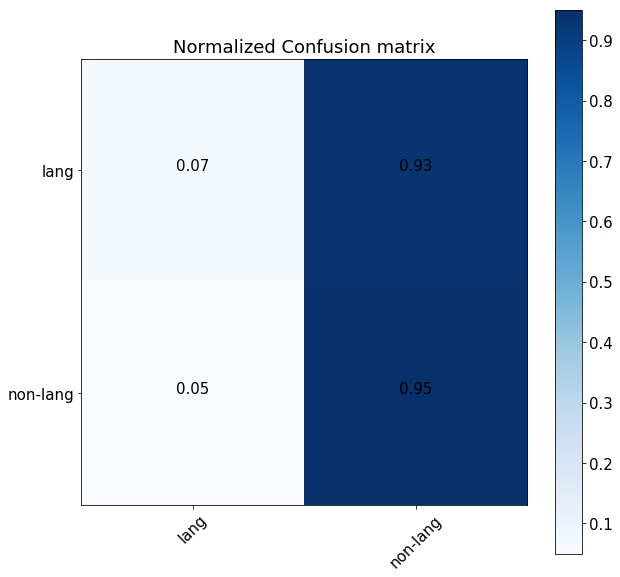

In [192]:
print("mean classification score", classifier(features,target))


In [22]:
import scipy
import pandas as pd
arr = []
for epoch in range(0,240):
    temp = []
    for channel in features[epoch]:
        hold = []
        var1 = np.mean(channel)
        skew1 = scipy.stats.skew(channel)
        kurtosis1 = scipy.stats.kurtosis(channel)
        hold.append(var1)
        hold.append(skew1)
        hold.append(kurtosis1)
        temp.append(hold)
    arr.append(temp)
    temp = []
    
arr=np.array(arr)
    
    
print(arr.shape)

(240, 125, 3)


In [23]:
print("mean classification score", classifier(arr,target))



original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.750
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.792
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.854
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.854
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.896
mean classification score 0.8291666666666666


In [160]:
def findImportantFeatures(feature_data,target):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target, random_state=0)

    forest = RandomForestClassifier(n_estimators=100, random_state=0)
    twoDimTrainData = Vectorizer().fit_transform(X_train)
    forest.fit(twoDimTrainData, y_train)
    
    twoDimTestData = Vectorizer().fit_transform(X_test)
    print('Accuracy on the training subset: {:.3f}'.format(forest.score(twoDimTrainData, y_train)))
    print('Accuracy on the test subset: {:.3f}'.format(forest.score(twoDimTestData, y_test)))
    
    print(forest.feature_importances_.shape)
    

    impt = []
    for e in forest.feature_importances_:
        impt.append(e)
    
    print("shape of important feat array: ",np.array(impt).shape)
    temp = []
    
    for i in range(0,375,3):
        #print(i)
        hold = []
        for j in range(i,i+3):
            hold.append(impt[j])
            
        temp.append(np.mean(hold))    
            
    print("new shape of important feat array: ",np.array(temp).shape)    
    
#     n_features = feature_data.shape[1]
#     print("n_features =  ",n_features)
#     plt.barh(range(n_features), temp, align='center')
#     #plt.yticks(np.arange(n_features))
#     plt.xlabel('Feature Importance')
#     plt.ylabel('Feature')
#     plt.show()
    
    ch_names = []
    four_channel_importances = []
    maxx = np.max(temp)
    print(maxx)
    print(temp.index(maxx))
    print(binary_epoch.ch_names[temp.index(maxx)])
    
    
    temp2 = temp.copy()
    temp2.remove(maxx)
            
    maxx2=np.max(temp2)
    print(maxx2)
    print(temp.index(maxx2))
    print(binary_epoch.ch_names[temp.index(maxx2)])
    
    temp3 = temp2.copy()
    temp3.remove(maxx2)
            
    maxx3=np.max(temp3)
    print(maxx3)
    print(temp.index(maxx3))
    print(binary_epoch.ch_names[temp.index(maxx3)])
    
    temp4 = temp3.copy()
    temp4.remove(maxx3)
            
    maxx4=np.max(temp4)
    print(maxx4)
    print(temp.index(maxx4))
    print(binary_epoch.ch_names[temp.index(maxx4)])
      
    ch_names.append(binary_epoch.ch_names[temp.index(maxx)])
    ch_names.append(binary_epoch.ch_names[temp.index(maxx2)])
    ch_names.append(binary_epoch.ch_names[temp.index(maxx3)])
    ch_names.append(binary_epoch.ch_names[temp.index(maxx4)])
    
    four_channel_importances.append(maxx)
    four_channel_importances.append(maxx2)
    four_channel_importances.append(maxx3)
    four_channel_importances.append(maxx4)
    
    plt.bar(ch_names,four_channel_importances)
    plt.xticks((binary_epoch.ch_names[temp.index(maxx)]),(binary_epoch.ch_names[temp.index(maxx2)])\
              ,(binary_epoch.ch_names[temp.index(maxx3)]),(binary_epoch.ch_names[temp.index(maxx4)]))
    
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.show()

Accuracy on the training subset: 1.000
Accuracy on the test subset: 0.883
(375,)
shape of important feat array:  (375,)
new shape of important feat array:  (125,)
0.02867364089637915
111
LB5
0.015155232589967134
54
RB2
0.01066122026973824
10
LA5
0.009378328986807344
112
LB6


TypeError: Illegal number of arguments to xticks

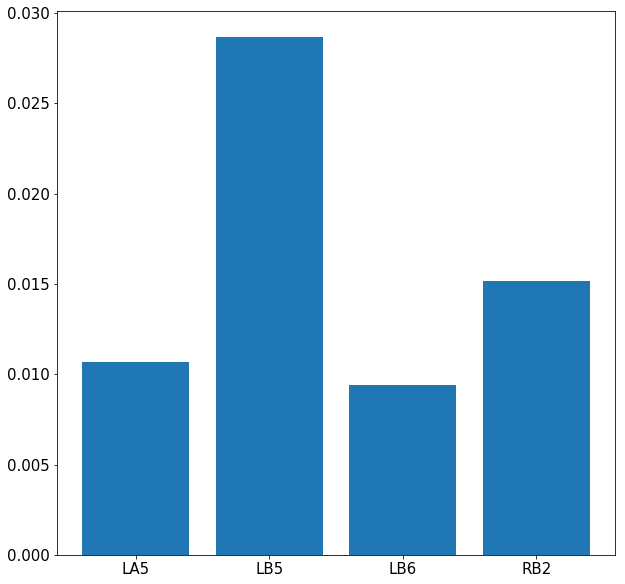

In [161]:
findImportantFeatures(arr,target)

In [101]:
#init pca and fit to data
from sklearn import preprocessing
print(arr.shape)
pca = UnsupervisedSpatialFilter(PCA(), average=False)
pca_data = pca.fit_transform(arr)


(240, 125, 3)


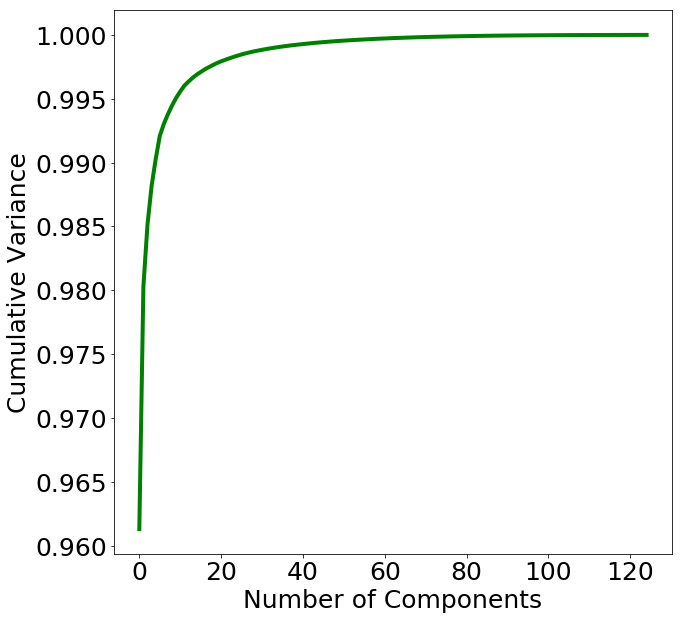

In [102]:
comp_variance = np.cumsum(pca.estimator.explained_variance_ratio_)
plt.plot(comp_variance, linewidth = 4.0, color = 'g')
plt.xlabel('Number of Components', fontsize = 25)
plt.ylabel('Cumulative Variance', fontsize = 25);
plt.xticks(fontsize = 25);
plt.yticks(fontsize = 25);

In [103]:
n_components = np.argwhere(comp_variance > .99)[0]
print(n_components)

[4]


In [165]:
montage2 = mne.channels.read_montage('ANT_DukeWaveGuard_128_electrode_montages_updated_V4',ch_names=['LA5','Lb5','LB6','RB2'])

ValueError: not enough values to unpack (expected 2, got 0)

original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.812
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.812
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.896
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.875
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.854
             precision    recall  f1-score   support

       lang       0.26      0.18      0.22        60
   non-lang       0.75      0.83      0.79       180

avg / total       0.63      0.67      0.65       240



NameError: name 'tight_layout' is not defined

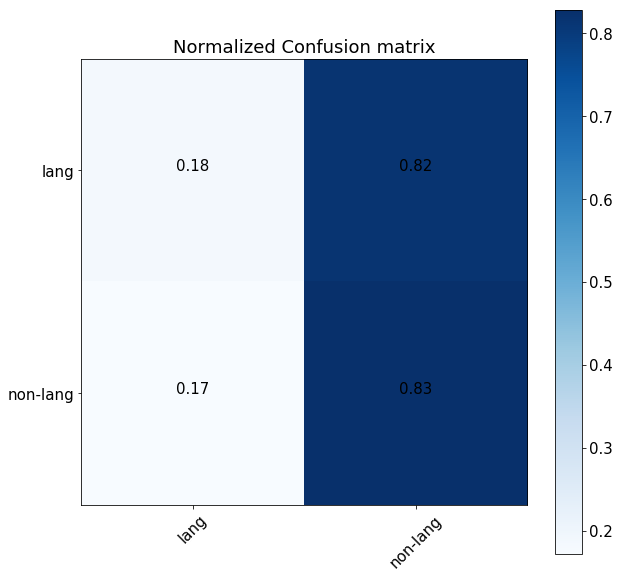

In [191]:
xca = UnsupervisedSpatialFilter(PCA(4), average=False)
xca_data = xca.fit_transform(arr)

classifier(xca_data,target)

In [183]:
target.shape

(240,)